In [1]:
import os
from argparse import Namespace
from pathlib import Path

import pytorch_lightning as pl
import torch
from torchvision import transforms
from torchvision.datasets import MNIST
from tqdm import trange

In [2]:
from dpsnn import SplitNN, ConvAttackModel, plot_images, AttackDataset

In [3]:
project_root = Path.cwd().resolve().parents[1]

---
# Noise during training
In this experiment,
we investigate the impact of adding laplacian noise to the intermediate tensor **during training**.
---

## Load target model
Load a model trained without noise

In [4]:
classifiers_path = project_root / "models" / "classifiers"
os.listdir(classifiers_path)

['mnist_02noise_00nopeek_epoch=07.ckpt',
 'mnist_10noise_00nopeek_epoch=08.ckpt',
 'mnist_01noise_00nopeek_epoch=06.ckpt',
 'mnist_05noise_00nopeek_epoch=08.ckpt',
 'mnist_00noise_00nopeek_epoch=06.ckpt',
 'mnist_00noise_01nopeek_epoch=09.ckpt',
 'mnist_00noise_10nopeek_epoch=09.ckpt',
 '.gitkeep',
 'mnist_00noise_05nopeek_epoch=08.ckpt']

In [5]:
def _load_classifier(model_name):
    checkpoint = torch.load(classifiers_path / model_name)
    hparams = checkpoint["hyper_parameters"]

    target_model = SplitNN(hparams)
    target_model.load_state_dict(checkpoint["state_dict"])
    target_model.prepare_data()

    return target_model

In [6]:
target_model00 = _load_classifier("mnist_00noise_00nopeek_epoch=06.ckpt")
target_model01 = _load_classifier("mnist_01noise_00nopeek_epoch=06.ckpt")
target_model05 = _load_classifier("mnist_05noise_00nopeek_epoch=08.ckpt")
target_model10 = _load_classifier("mnist_10noise_00nopeek_epoch=08.ckpt")

target_models = [target_model00, target_model01, target_model05, target_model10]

## Confirm target model performance

In [7]:
target_trainer = pl.Trainer(gpus=None, overfit_batches=0.5)  # use half of validation data

for _model in [target_model00, target_model01, target_model05, target_model10]:
    target_trainer.test(_model, _model.val_dataloader())

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
/home/tom/anaconda3/envs/dpsnn/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_loss': tensor(1.4697),
 'test_acc': tensor(99.3640),
 'test_loss': tensor(1.4697)}
--------------------------------------------------------------------------------



/home/tom/anaconda3/envs/dpsnn/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The testing_epoch_end should not return anything as of 9.1.to log, use self.log(...) or self.write(...) directly in the LightningModule
  warnings.warn(*args, **kwargs)
/home/tom/anaconda3/envs/dpsnn/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The {log:dict keyword} was deprecated in 0.9.1 and will be removed in 1.0.0
Please use self.log(...) inside the lightningModule instead.

# log on a step or aggregate epoch metric to the logger and/or progress bar
# (inside LightningModule)
self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
  warnings.warn(*args, **kwargs)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_loss': tensor(1.4700),
 'test_acc': tensor(99.3089),
 'test_loss': tensor(1.4700)}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_loss': tensor(1.4693),
 'test_acc': tensor(99.3690),
 'test_loss': tensor(1.4693)}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_loss': tensor(1.4730),
 'test_acc': tensor(98.9934),
 'test_loss': tensor(1.4730)}
--------------------------------------------------------------------------------



---
# Attack models

## Get validation set for attackers

- Classifier is trained on first `40'000` MNIST "train" images
- Attacker is trained on `40'000-45'000` first MNIST "train" images
- Validate attacker on MNIST "train" images `45'000-50'000`

In [8]:
transform = transforms.Compose(
        [
            transforms.ToTensor(),
            # PyTorch examples; https://github.com/pytorch/examples/blob/master/mnist/main.py
            transforms.Normalize((0.1307,), (0.3081,)),
        ]
)

attack_val_dataset = torch.utils.data.Subset(
        MNIST(project_root / "data", download=True, train=True, transform=transform),
        range(45_000, 50_000),
)

## Load attackers

In [9]:
attackers_dir = project_root / "models" / "attackers"
os.listdir(attackers_dir)

['mnist_attacker_model<mnist_05noise_00nopeek.ckpt',
 'mnist_attacker_model<mnist_10noise_00nopeek.ckpt',
 'mnist_attacker_model<mnist_00noise_00nopeek.ckpt',
 'mnist_attacker_model<mnist_01noise_00nopeek.ckpt',
 '.gitkeep']

In [10]:
def _load_attacker(attacker_name):
    attack_model = ConvAttackModel({})
    attack_model.load_state_dict(torch.load(attackers_dir / attacker_name))
    attack_model.eval()

    return attack_model

In [11]:
attack_model00 = _load_attacker("mnist_attacker_model<mnist_00noise_00nopeek.ckpt")
attack_model01 = _load_attacker("mnist_attacker_model<mnist_01noise_00nopeek.ckpt")
attack_model05 = _load_attacker("mnist_attacker_model<mnist_05noise_00nopeek.ckpt")
attack_model10 = _load_attacker("mnist_attacker_model<mnist_10noise_00nopeek.ckpt")

attack_models = [attack_model00, attack_model01, attack_model05, attack_model10]

## Visualise reconstruction

### 0.0 noise

torch.Size([20, 1, 28, 28])
torch.Size([3, 152, 122])


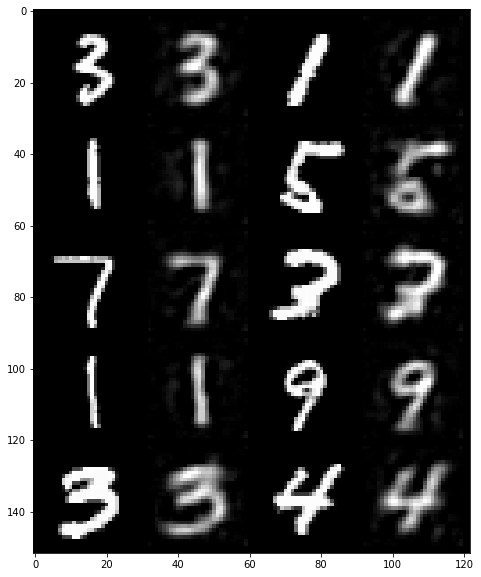

In [22]:
ims = []

for i in range(10):
    image, _ = attack_val_dataset[i]
    with torch.no_grad():
        intermediate = target_model00.encode(image.unsqueeze(0))
        reconstructed = attack_model00(intermediate)

    reconstructed = reconstructed.squeeze(0)
    ims.extend([image, reconstructed])

plot_images(ims, rows=4)

### 0.1 noise

torch.Size([20, 1, 28, 28])
torch.Size([3, 152, 122])


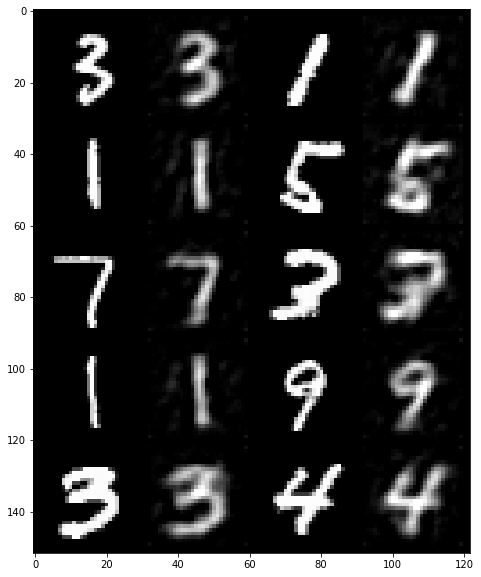

In [21]:
ims = []

for i in range(10):
    image, _ = attack_val_dataset[i]
    with torch.no_grad():
        intermediate = target_model01.encode(image.unsqueeze(0))
        reconstructed = attack_model01(intermediate)

    reconstructed = reconstructed.squeeze(0)
    ims.extend([image, reconstructed])

plot_images(ims, rows=4)

### 0.5 noise

torch.Size([20, 1, 28, 28])
torch.Size([3, 152, 122])


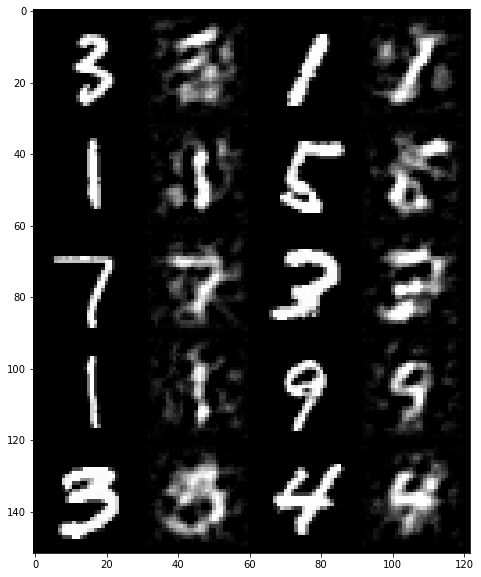

In [20]:
ims = []

for i in range(10):
    image, _ = attack_val_dataset[i]
    with torch.no_grad():
        intermediate = target_model05.encode(image.unsqueeze(0))
        reconstructed = attack_model05(intermediate)

    reconstructed = reconstructed.squeeze(0)
    ims.extend([image, reconstructed])

plot_images(ims, rows=4)

### 1.0 noise

torch.Size([20, 1, 28, 28])
torch.Size([3, 152, 122])


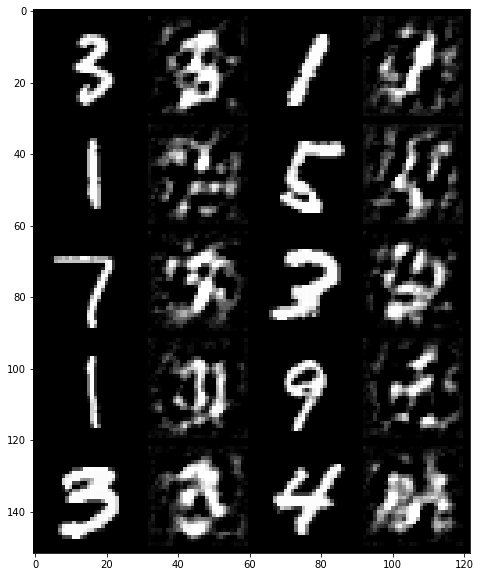

In [19]:
ims = []

for i in range(10):
    image, _ = attack_val_dataset[i]
    with torch.no_grad():
        intermediate = target_model10.encode(image.unsqueeze(0))
        reconstructed = attack_model10(intermediate)

    reconstructed = reconstructed.squeeze(0)
    ims.extend([image, reconstructed])

plot_images(ims, rows=4)

### Side-by-side comparison

torch.Size([25, 1, 28, 28])
torch.Size([3, 152, 152])


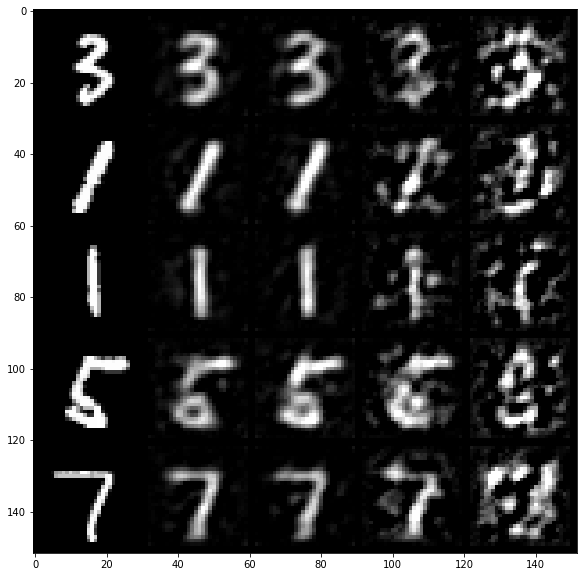

In [23]:
ims = []

for i in range(5):
    image_idx = 100 + i  # showcase different images

    image, _ = attack_val_dataset[i]
    ims.append(image)

    for target_model, attack_model in zip(target_models, attack_models):
        with torch.no_grad():
            intermediate = target_model.encode(image.unsqueeze(0))
            reconstructed = attack_model(intermediate)

        reconstructed = reconstructed.squeeze(0)
        ims.append(reconstructed)

plot_images(ims, rows=5)